# Identificación de un péndulo simple

Se presenta 
- un simulador del sistema no lineal, 
- una función para generar un dataset de estimación y validación, 
- una celda para estimar utilizando la pseudoinversa de la matriz de regresores
- una función para validar resultados

El objetivo es evaluar las distintas combinaciones de datos del regresor y cómo esto impacta en la estimación, la confianza en los parámetros estimados, y el significado en cuanto a la capacidad de predecir a un paso o bien en simulación

El modelo del sistema es
$$ \ddot{\theta} = -\frac{b}{ml^2}\dot{\theta} - \frac{g}{l} \sin(\theta) + \frac{1}{ml^2} u$$

Se pueden incluir términos no lineales ajustando los valores que se cargan en el regresor.
Por ejemplo, es posible plantear un modelo NARX:
$$  y_k = - a_1 y_{k-1} - a_2 y_{k-2} + a_3 \sin(y_{k-2}) + b_1 u_{k-1} + b_2 u_{k-2}$$


In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy as sp


## Simulador

In [67]:
# Dinámica no lineal del péndulo simple con torque de entrada u(t)
def pendulo(t, x, u, Ts):
    # Parámetros del péndulo
    m = 1.0    # masa [kg]
    l = 1.0    # longitud [m]
    g = 9.81   # gravedad [m/s^2]
    b = 1.25   # coeficiente de fricción viscosa [N·m·s]

    # Indice de la muestra actual
    k = int(np.floor(t / Ts))
    if k < 0: 
        k = 0
    if k >= len(u):
        k = len(u) - 1

    theta, omega = x  # posición angular, velocidad angular
    dtheta = omega
    domega = -(b/(m*l**2))*omega - (g/l)*np.sin(theta) + u[k]/(m*l**2)
    return [dtheta, domega]

def simular_pendulo(t_samples, u, x0 = [0, 0.0], plot=True):
    #sol = solve_ivp(lambda t, x: pendulo(t, x, u_func), t_span, x0, t_eval=t_eval, rtol=1e-6, atol=1e-8)
    Ts = t_samples[1] - t_samples[0]
    sol = solve_ivp(lambda t, x: pendulo(t, x, u, Ts), (0,t_samples[-1]), x0, t_eval=t_samples)
    
    if plot:
        # Graficar resultados
        plt.figure()
        plt.subplot(3,1,1)
        plt.plot(t_samples, sol.y[0])
        plt.ylabel(r"$\theta$ [rad]")
        plt.grid(True)

        plt.subplot(3,1,2)
        plt.plot(t_samples, sol.y[1])
        plt.ylabel(r"$\dot{\theta}$ [rad/s]")
        plt.grid(True)

        plt.subplot(3,1,3)
        plt.step(t_samples, u,where='post')
        plt.ylabel("Torque [Nm]")
        plt.xlabel("Tiempo [s]")
        plt.grid(True)
        plt.show()


        plt.figure()
        plt.plot(sol.y[0], sol.y[1])
        plt.xlabel(r"$\theta$ [rad]")
        plt.ylabel(r"$\dot{\theta}$ [rad/s]")   
        plt.show()
    return sol.t,sol.y[0],sol.y[1]

## Generación del dataset

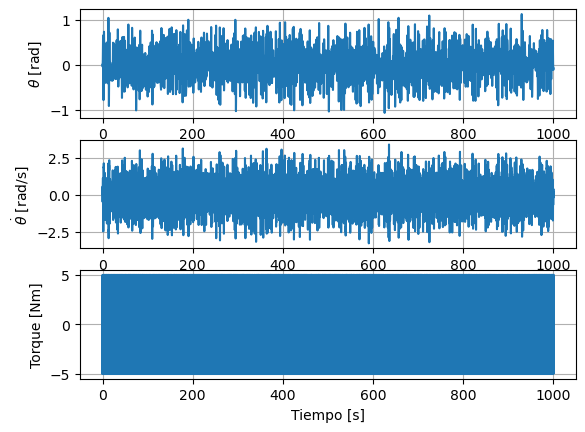

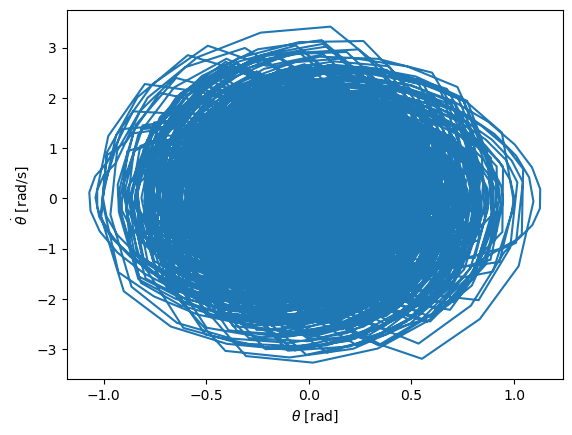

In [272]:
# Generación del dataset de identificación y validación

# Condiciones de la simulación
N = 10001                # número de muestras
N_train = int(0.7 * N)  # usar 70% de los datos para entrenamiento
N_val = N - N_train     # 30% para validación
Ts = 0.1                # tiempo de muestreo [s]
t_final = (N-1)*Ts 

# Generar PRBS (pseudo-random binary sequence) como entrada
np.random.seed(0)  # reproducibilidad
tau_max = 5
u = np.random.choice([-tau_max, tau_max], size=N)  # torque Nm
t_samples = np.linspace(0, t_final, N)

t,theta,omega = simular_pendulo(t_samples, u, x0 = [0.0, 0.0])

# La entrada es el vector de torques, y la salida es la posición angular
u_train = u[0:N_train].reshape(-1)  # entrada (torque)
y_train = theta[0:N_train].reshape(-1)   # salida (posición angular)
u_val = u[N_train:N].reshape(-1)  # entrada de validación
y_val = theta[N_train:N].reshape(-1) # salida de validación
t_val = t_samples[N_train:N]


## Estimación

In [280]:
# Orden del modelo (según lo planteado)
k0 = 3  # necesitamos y_{k-1}, y_{k-2}, u_{k-1} => primero k usable es 2 (index base 0)

def construir_regresor(y, u, k):
    """Construye el vector de regresores phi_k para el tiempo k."""
    return np.array([
        y[k-1],       
        y[k-1]-y[k-2],
        #y[k-2],       
        #np.sin(y[k-1]),
        np.sin(y[k-2]),
        #np.cos(y[k-1]),
        #np.cos(y[k-2]),
        u[k-1],
        u[k-2],
        #u[k-3],
    ])

# Construir Phi y y_target
Phi_rows = []
y_target = []
for k in range(k0, N_train):
    row = construir_regresor(y_train, u_train, k)
    Phi_rows.append(row)
    y_target.append(y_train[k])

Phi = np.asarray(Phi_rows)       
M, p = Phi.shape
np.set_printoptions(precision=4, suppress=True)
print("Matriz de correlación entre columnas de Phi:\n", np.corrcoef(Phi.T))

Phi_mean = Phi.mean(axis=0)
Phi_std = Phi.std(axis=0, ddof=1)
print("Media de los regresores:", Phi_mean)
print("Desvío estándar de los regresores:", Phi_std)
# Normalizamos Phi para ayudar al condicionamiento numérico
Phi_mean = np.zeros_like(Phi_mean)
Phi = (Phi - Phi_mean) / Phi_std
y_target = np.asarray(y_target)  

# --- Estimador por pseudoinversa (mínimos cuadrados ordinarios) ---
Theta_hat = np.linalg.pinv(Phi) @ y_target   

# Calculo los residuos sobre el set de entrenamiento
residuos = y_train[k0:] - Phi @ Theta_hat

# SVD y condicionamiento
U, s, Vt = sp.linalg.svd(Phi, full_matrices=False)
cond_Phi = s[0] / s[-1]
print("Valores singulares de Phi =", s)
print(f"Número de condición de Phi = {cond_Phi:.3f}")

# Última fila de Vt (o columna de V) corresponde al modo con s_min
print("Modo de menor energía:", Vt[-1,:])

# Residuos y sigma^2 estimado
RSS = np.sum(residuos**2)
dof = max(1, M - p)  # grados de libertad
sigma2_hat = RSS / dof
sigma_hat = np.sqrt(sigma2_hat)
print("\nRSS = {:.6f}, sigma_hat = {:.6f}, dof = {}".format(RSS, sigma_hat, dof))

# Covarianza del estimador
cov_theta = sigma2_hat * sp.linalg.pinv(Phi.T @ Phi)   # (p x p)
se = np.sqrt(np.diag(cov_theta))
print("Desvio estándar de la estimación:", se)

# Construyo intervalos de confianza (t-student)
alpha = 0.05
tcrit = sp.stats.t.ppf(1 - alpha/2, df=dof)
ci_lower = Theta_hat - tcrit * se
ci_upper = Theta_hat + tcrit * se
print(f"\nEstimaciones e intervalos de confianza ({1-alpha:.0%}):")
for i in range(p):
    print(f"theta[{i}]: {Theta_hat[i]:.6f}  se={se[i]:.6f}  CI=[{ci_lower[i]:.6f}, {ci_upper[i]:.6f}]")

# Varianza en direcciones singulares (modo V)
var_along_modes = sigma2_hat / (s**2)   # var en cada modo v_i
print("\nVar en modos SVD (sigma^2 / s_i^2):", var_along_modes)

# Opcional: fracción de varianza explicada por cada modo
# (útil para ver si truncar modos pequeños)
mode_energy = s**2
mode_energy_frac = mode_energy / np.sum(mode_energy)
print("Fracción de energía por modo:", mode_energy_frac)


Matriz de correlación entre columnas de Phi:
 [[ 1.      0.1464  0.9568  0.0063  0.0797]
 [ 0.1464  1.     -0.1445  0.0204  0.2516]
 [ 0.9568 -0.1445  1.      0.0002  0.0063]
 [ 0.0063  0.0204  0.0002  1.      0.0089]
 [ 0.0797  0.2516  0.0063  0.0089  1.    ]]
Media de los regresores: [-0.0004  0.0001 -0.0006  0.0407  0.0422]
Desvío estándar de los regresores: [0.3635 0.1056 0.3421 5.0002 5.0002]
Valores singulares de Phi = [117.1288  94.5553  83.5864  72.994    2.5173]
Número de condición de Phi = 46.530
Modo de menor energía: [ 0.6927 -0.2016 -0.6925 -0.0001 -0.0002]

RSS = 0.693448, sigma_hat = 0.009959, dof = 6992
Desvio estándar de la estimación: [0.0027 0.0008 0.0027 0.0001 0.0001]

Estimaciones e intervalos de confianza (95%):
theta[0]: 0.352044  se=0.002741  CI=[0.346671, 0.357418]
theta[1]: 0.088461  se=0.000806  CI=[0.086880, 0.090041]
theta[2]: -0.019518  se=0.002740  CI=[-0.024890, -0.014146]
theta[3]: 0.024668  se=0.000119  CI=[0.024434, 0.024901]
theta[4]: 0.021700  se=0

## Validación

RMSE 1-step: 0.0154365
RMSE simulación libre (multi-step): 0.0972266


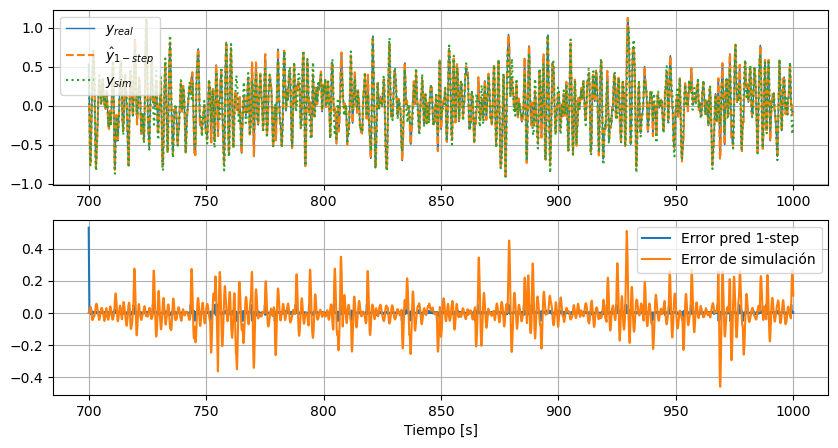

In [281]:
# Función de validación 
def validar_modelo(t,u,y,Theta_hat,plot=True):
    N = len(y)
    y_hat = np.zeros_like(y)
    y_sim = y.copy()
    for k in range (k0, N):
        # --- Predicción 1-step (en-sample) ---
        phi = (construir_regresor(y, u, k)-Phi_mean)/Phi_std  
        #phi = construir_regresor(y, u, k) 
        y_hat[k] = float(phi @ Theta_hat)

        # --- Simulación 
        phi = (construir_regresor(y_sim, u, k)-Phi_mean)/Phi_std
        #phi = construir_regresor(y_sim, u, k) 
        y_sim[k] = float(phi @ Theta_hat)

    rmse_1step = np.sqrt(np.mean((y - y_hat)**2))
    print(f"RMSE 1-step: {rmse_1step:.6g}")

    rmse_sim = np.sqrt(np.mean((y - y_sim)**2))
    print(f"RMSE simulación libre (multi-step): {rmse_sim:.6g}")

    if plot:
        plt.figure(figsize=(10,5))
        plt.subplot(211)
        plt.plot(t, y, label='$y_{real}$', linewidth=1)
        plt.plot(t, y_hat, '--', label='$\hat{y}_{1-step}$')
        plt.plot(t, y_sim, ':', label='$y_{sim}$')
        plt.legend()        
        plt.grid(True)
        plt.subplot(212)
        plt.plot(t, y - y_hat, label='Error pred 1-step')
        plt.plot(t, y - y_sim, label='Error de simulación')
        plt.legend()
        plt.xlabel('Tiempo [s]')
        plt.grid()    
        plt.show()

    return y_hat, y_sim

y_hat,_  = validar_modelo(t_val,u_val,y_val,Theta_hat,plot=True)

## Validación de la respuesta al escalón

RMSE 1-step: 0.000450271
RMSE simulación libre (multi-step): 0.00636469


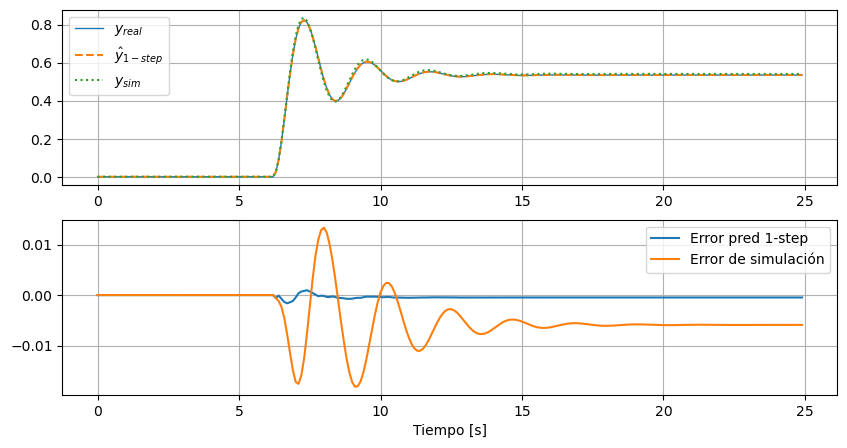

In [282]:
# Probamos la simulación con un escalón

# Condiciones de la simulación
N = 250    # número de muestras
t_final = (N-1)*Ts 
t_samples = np.linspace(0, t_final, N)

u = np.zeros_like(t_samples) 
u[-N*3//4:] = 5
t,theta,omega = simular_pendulo(t_samples, u, x0 = [0.0, 0.0],plot=False)
_ = validar_modelo(t,u,theta,Theta_hat,plot=True)

